## 1. GBM(Gradient Boosting Machine)

부스팅 알고리즘 )
- 에이다 부스트 : 오류 데이터에 가중치를 부여하며 부스팅을 수행
- 그래디언트 부스트

GBM )
- 가중치 업데이트 → 경사 하강법 이용   
→ 오류식을 최소화하는 방향성을 가지고 반복적으로 가중치 값을 업데이트
- 분류뿐만 아니라 회귀에서도 사용 가능
- 사이킷런 → GradientBoostingClassifier 클래스 제공

In [1]:
## 앞서 진행한 get_human_dataset() 이용, GBM 실습

# 중복된 피처명 → _1 또는 _2 추가해 새 피처명 생성하는 함수 생성
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), columns = ['dup_cnt']) # cumcount : 각 그룹별로 소속 데이터에 번호 부여
  feature_dup_df = feature_dup_df.reset_index()
  
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x: x[0] + '_' + str(x[1]) if x[1] > 0 else x[0],  axis = 1)
  new_feature_name_df = new_feature_name_df.drop(['index'], axis = 1)

  return new_feature_name_df

In [2]:
# train, test 데이터셋 → DataFrame에 로드
def get_human_dataset():

  # 각 데이터 파일 → 공백으로 분리되어 있음
  feature_name_df = pd.read_csv('/content/drive/MyDrive/ML/human_activity/features.txt', sep = '\s+', header = None, names = ['column_index', 'column_name'])

  # 중복 피처명 수정
  new_feature_name_df = get_new_feature_name_df(feature_name_df)
  # 피처명을 칼럼으로 부여하기 위한 리스트 생성
  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

  # 학습용/테스트용 데이터셋 로드
  X_train = pd.read_csv('/content/drive/MyDrive/ML/human_activity/train/X_train.txt', sep = '\s+', names = feature_name)
  X_test = pd.read_csv('/content/drive/MyDrive/ML/human_activity/test/X_test.txt', sep = '\s+', names = feature_name)

  y_train = pd.read_csv('/content/drive/MyDrive/ML/human_activity/train/y_train.txt', sep = '\s+', header = None, names = ['action'])
  y_test = pd.read_csv('/content/drive/MyDrive/ML/human_activity/test/y_test.txt', sep = '\s+', header = None, names = ['action'])

  return X_train, X_test, y_train, y_test

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# 수행 시간 측정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f} 초'.format(time.time() - start_time))

GBM 정확도: 0.9386
GBM 수행 시간: 791.7 초


기본 하이퍼 파라미터만으로도 높은 정확도를 보임(약 93.86%)   
하지만 병렬 처리가 지원되지 않기 때문에 수행 시간이 굉장히 오래 걸리는 편

### 하이퍼 파라미터, 튜닝

- loss : 경사 하강법에서 사용할 비용 함수 지정(기본값 = 'deviance')
- learning_rate : 학습을 진행할 때마다 적용하는 학습률(기본값 = 0.1)   
너무 작으면 최소 오류 값을 찾지 못할 수 있고 너무 크면 예측 성능은 떨어지나 빠른 수행이 가능   
→ learning_rate, n_estimators와 상호 보완적으로 조합해 사용   
- n_estimators : weak learner의 개수(기본값 = 100)
- subsample : weak learner가 학습에 사용하는 데이터의 샘플링 비율(기본값 = 1)   
과적합이 걱정될 경우 1보다 작은 값으로 설정

## 2. XGBoost(eXtra Gradient Boost)

### 개요

- 뛰어난 예측 성능 : 분류와 회귀 영역에서 뛰어난 예측 성능을 보임
- GBM 대비 빠른 수행 시간 : 병렬 학습이 가능하기 때문에 수행 시간이 빨라짐
- 과적합 규제
- Tree Pruning : 더 이상 긍정 이득이 없는 분할을 가지치기, 분할 수를 더 줄임
- 자체 내장된 교차 검증 : 조기 중단 기능 탑재
- 결손값 자체 처리

### 하이퍼 파라미터

주요 일반 파라미터 )
- booster : gbtree(tree based model) 또는 gblinear(linear model) 선택 (기본값 = gbtree)
- silent : 출력 메시지를 나타내고 싶지 않을 경우 1로 설정 (기본값 = 0)
- nthread : CPU 실행 스레드 개수 조정

주요 부스터 파라미터 )
- learning_rate : GBM의 학습률과 같은 파라미터 (기본값 = 0.3)   
일반적으로 0.1 ~ 0.2 사이의 값을 선호
- n_estimatos : GBM의 n_estimatos와 같음
- max_depth : 일반적으로 3 ~ 10 사이의 값
- subsample : 일반적으로 0.5 ~ 1

과적합 문제가 심각할 경우 적용할 파라미터 )
- eta 값을 낮춤(0.01 ~ 0.1) → num_round 또는 n_estimators는 높여줘야 함
- max_depth 값 낮춤
- min_child_weight 값 높임
- gamma 값 높임
- subsample, colsample_bytree 값 조정

### 위스콘신 유방암 예측 (XGBoost)

종양의 크기, 모양 등의 다양한 속성값을 기반으로 악성 종양/양성 종양인지를 분류한 데이터셋

In [4]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data = X_features, columns = dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [5]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


타겟 레이블 값 : 악성(malignant) = 0, 양성(benign) = 1

In [6]:
# 데이터 분할 → 학습용 80%, 테스트용 20%
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)

print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [7]:
# 사이킷런 래퍼 XGboost 클래스인 XGBClassifer 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [9]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


조기 중단 관련 파라미터 : fit( ) 의 파라미터에 입력
- early_stopping_rounds
- eval_metric : 조기 중단을 위한 평가 지표
- eval_set : 성능 평가를 수행할 데이터 셋   
→ 성능 평가 데이터셋은 학습 데이터와는 별도의 데이터셋이어야 함 ( 완전히 알려지지 않은 데이터셋 )

In [10]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
evals = [(X_test, y_test)] # 데이터 개수가 작아 부득이하게 테스트 데이터셋 사용

xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'logloss', eval_set = evals, verbose = True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

211번에서 311번까지 early_stopping_rounds로 설정한 100번 반복 동안 성능 평가 지수가 향상되지 않았기 때문에 조기 종료

In [11]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


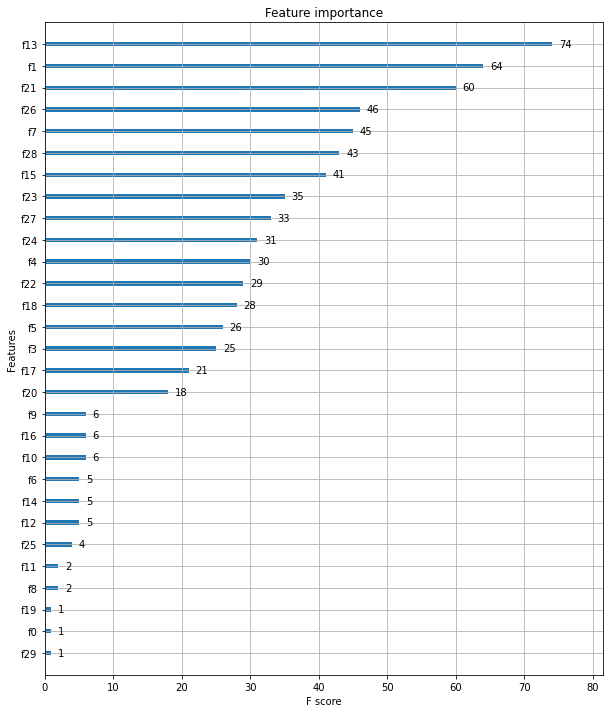

In [12]:
# 피처 중요도 시각화
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(xgb_wrapper, ax = ax)

## 3. LightGBM

- XGBoost보다 학습에 걸리는 시간이 훨씬 적음
- 메모리 사용량이 상대적으로 적음
- XGBoost와 예측 성능이 크게 차이 나지 않음
- 적은 데이터셋에 적용할 경우 과적합이 발생하기 쉬움(약 10,000개 이하의 데이터셋)
- 카테고리형 피처 자동 변환 및 최적 분할 지원

일반적인 트리 기반 알고리즘 : 균형 트리 분할   
→ 최대한 균형 잡힌 트리를 유지하며 트리의 깊이를 효과적으로 줄임 → 오버피팅에 강함   
LightGBM → 리프 중심 트리 분할 사용   
→ 최대 손실 값을 가지는 리프 노드를 지속적으로 분할 → 예측 오류 손실 최소화

### 하이퍼 파라미터

주의 : 리프 노드가 지속적으로 분할하면서 트리의 깊이가 깊어지기 때문에 max_depth를 매우 크게 가지는 편

주요 파라미터 )
- num_leaves : 하나의 트리가 가질 수 있는 최대 리프 개수
- min_child_samples : 최종 결정 클래스인 리프 노드가 되기 위해 최소한으로 필요한 레코드 수
- max_depth : 기존 트리 기반 알고리즘의 max_depth와 동일. 단, 깊이가 상대적으로 더 깊음

하이퍼 파라미터 튜닝 방안 )
- num_leaves : 개수를 높이면 정확도가 높아지나 깊이가 깊어지고 모델 복잡도가 커져 과적합 영향이 커짐
- min_child_samples : 과적합을 개선하기 위한 파라미터. 일반적으로 큰 값으로 설정할 경우 트리가 과도하게 깊어지는 것을 방지
- max_depth : 과적합을 개선할 때 사용
- learning_rate ↓, n_estimators ↑ : 부스팅 계열 튜닝의 가장 기본적인 방법. n_estimators가 너무 커질 경우 과적합 발생 위험

### 위스콘신 유방암 예측 (LightGBM)

In [13]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size = 0.2, random_state = 156)

lgbm_wrapper = LGBMClassifier(n_estimators = 400)

evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'logloss', eval_set = evals, verbose = True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.565079	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.507451	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865	valid_0's bi

In [14]:
# 예측 성능 평가
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 2 75]]
정확도: 0.9474, 정밀도: 0.9494, 재현율: 0.9740,    F1: 0.9615, AUC:0.9926


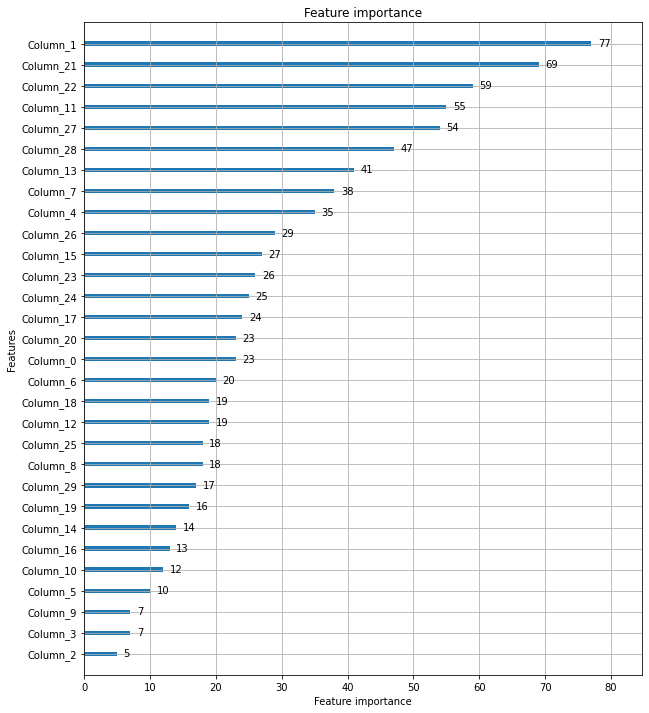

In [15]:
# 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(lgbm_wrapper, ax = ax)